# Fussing about with VLT/FORS2

In [24]:
%matplotlib notebook

In [49]:
# imports
from matplotlib import pyplot as plt

import numpy as np

from astropy.io import fits
from astropy import units

from pypeit.core.wavecal import waveio, wvutils, fitting
from pypeit import wavecalib 
from pypeit.core import wave

## Load a frame

In [13]:
dfile = '/data/VLT/FORS2/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.357.fits'
dfile = '/home/xavier/scratch/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.356.fits' #FORS2.2018-12-05T02:33:49.816.fits'
dfile = '/home/xavier/scratch/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T12:19:37.190.fits' # arc

In [14]:
hdu = fits.open(dfile)

In [15]:
hdu[0].header

 [astropy.io.fits.verify]


SIMPLE  =                    T          / Standard FITS format (NOST-100.0)     
BITPIX  =                   16          / # of bits storing pix values          
NAXIS   =                    2          / # of axes in frame                    
NAXIS1  =                 2048          / # pixels/axis                         
NAXIS2  =                 1034          / # pixels/axis                         
ORIGIN  = 'ESO     '                    / European Southern Observatory         
DATE    = '2018-12-05T12:24:40.045'     / UT date when this file was written    
MJD-OBS =       58457.51362488          / MJD start (2018-12-05T12:19:37.190)   
DATE-OBS= '2018-12-05T12:19:37.189'     / Date of observation                   
EXPTIME =             299.9848          / Total integration time                
CRVAL1  =           2045.63600          / value of ref pixel                    
CRPIX1  =               1022.8          / Ref pixel in x-axis                   
CTYPE1  = 'PIXEL   '        

In [28]:
hdu.info()

Filename: /data/VLT/FORS2/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.357.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CHIP2         1 PrimaryHDU     290   (2048, 1034)   int16 (rescales to uint16)   


### Chip 1?

In [31]:
dfile2 = '/data/VLT/FORS2/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.356.fits'

In [33]:
hdu = fits.open(dfile2)
hdu.info()

Filename: /data/VLT/FORS2/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.356.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CHIP1         1 PrimaryHDU     275   (2048, 1034)   int16 (rescales to uint16)   


----

## Wavelengths

In [16]:
wv_file = '/home/xavier/scratch/FRB181112/FORS2/vlt_fors2_E/MF_vlt_fors2/MasterWaveCalib_E_1_01.json'

In [21]:
wvcalib, par = wavecalib.load_wv_calib(wv_file)

[INFO]    :: wavecalib.py 331 load_master() - Loading Master wv_calib frame:
             /home/xavier/scratch/FRB181112/FORS2/vlt_fors2_E/MF_vlt_fors2/MasterWaveCalib_E_1_01.json


In [23]:
wvcalib['0'].keys()

dict_keys(['cen_disp', 'cen_wave', 'fitc', 'fmax', 'fmin', 'function', 'ions', 'mask', 'nrej', 'nspec', 'pixel_fit', 'rms', 'shift', 'spec', 'tcent', 'wave_fit', 'wave_soln', 'weights', 'xnorm', 'xrej', 'yrej'])

### ID a few by hand

In [29]:
spec = wvcalib['0']['spec']

<IPython.core.display.Javascript object>


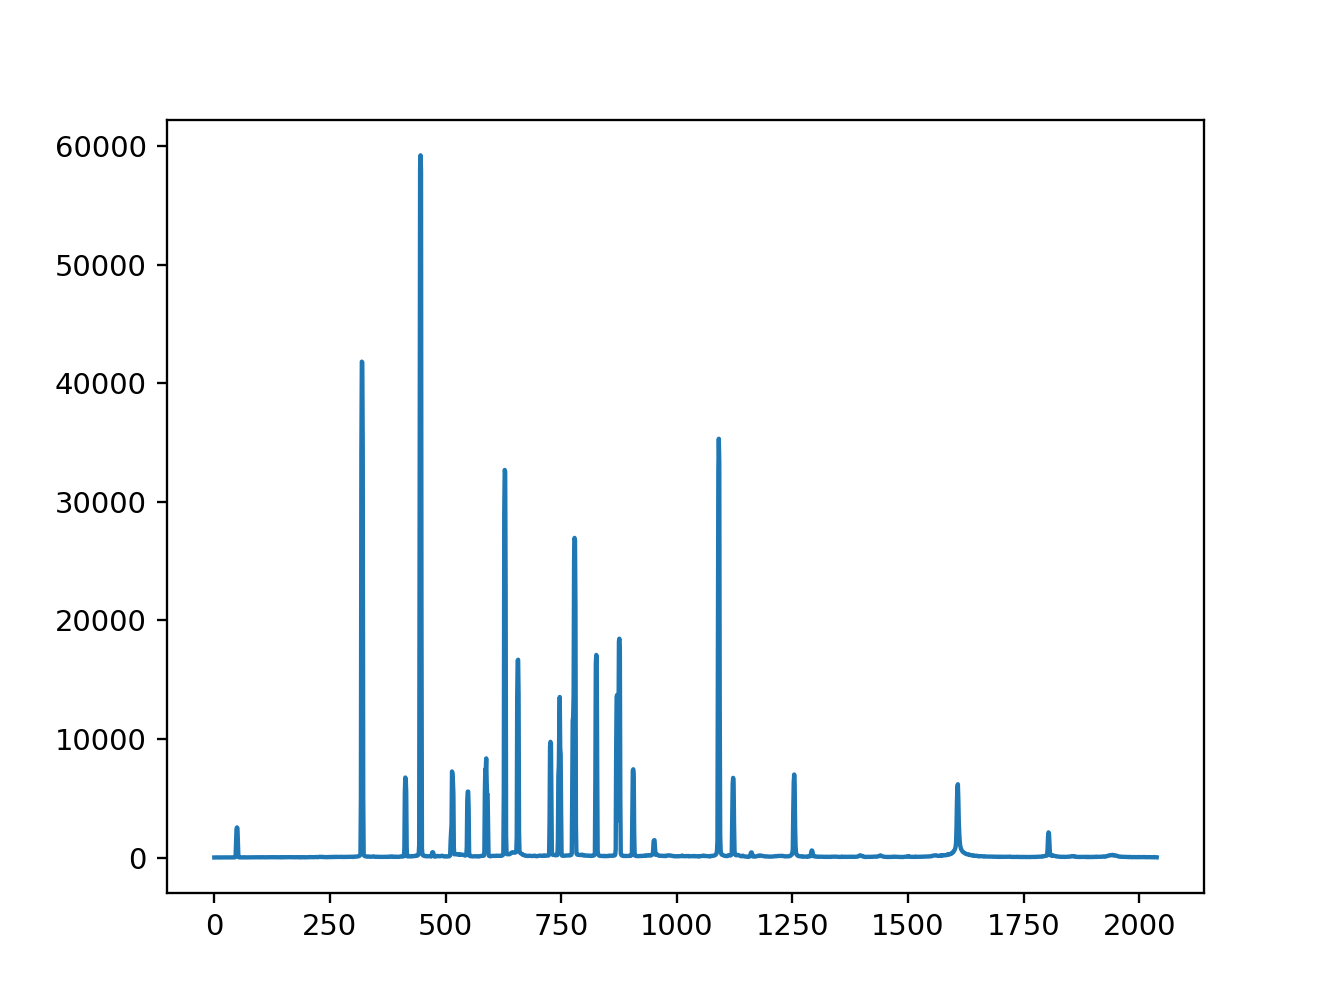

In [58]:
plt.clf()
ax = plt.gca()
ax.plot(spec)
plt.show()

### Find the lines

In [31]:
all_tcent, all_ecent, cut_tcent, icut, arc_cont_sub = wvutils.arc_lines_from_spec(spec)

In [42]:
wave.airtovac([9784.5, 10830.17]*units.AA)

<Quantity [ 9787.18326012, 10833.13678069] Angstrom>

In [59]:
pIDs = [49.0, 548.4, 905.8, 1253.9, 1607.6]   # Approx
wvID = [5877.2490, 7386.0140,  8523.7830, 9660.4350,  10833.137]

In [60]:
iIDs = []
for pID in pIDs:
    idx = np.argmin(np.abs(pID-all_tcent))
    iIDs.append(idx)
iIDs = np.array(iIDs)
iIDs

array([ 0,  6, 16, 21, 25])

### Linelist

In [61]:
llist = waveio.load_line_lists(['ArI', 'HeI'])

### Fit

In [62]:
spec.size

2039

In [63]:
fit = fitting.iterative_fitting(spec, all_tcent, iIDs, wvID, llist, 11., plot_fil='vlt_fors2.png', n_first=3, verbose=True) 

[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 3: RMS = 0.0232565
[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 4: RMS = 0.00347521
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 6679.13; 6679.92
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 7069.17; 7067.23
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 7274.94; 7282.53
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 7505.94; 7508.73
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 8016.99; 8013.12
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 8117.54; 8116.18
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 8410.52; 8411.64
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 9356.79; 9356.56


In [53]:
fit

{'cen_disp': 3.251261352103029,
 'cen_wave': 8732.397982804467,
 'fitc': array([ 8.88354377e+03,  3.37303605e+03,  3.00880052e+02,  9.59759114e+00,
        -6.21733651e+00, -2.43223471e+01]),
 'fmax': 1.0,
 'fmin': 0.0,
 'function': 'legendre',
 'ions': array(['ArI', 'ArI', 'ArI', 'ArI', 'ArI', 'ArI', 'ArI', 'ArI', 'ArI',
        'ArI', 'ArI', 'ArI', 'ArI', 'UNKNWN', 'ArI', 'ArI', 'UNKNWN',
        'ArI', 'ArI'], dtype='<U6'),
 'mask': array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,
         True]),
 'nrej': 3.0,
 'nspec': 2039,
 'pixel_fit': array([  49.03589971,  413.51124972,  445.89634082,  472.3132417 ,
         515.25656786,  548.39187332,  587.5302364 ,  628.34294518,
         746.78860524,  779.04460094,  826.04965695,  871.05864567,
         875.7717699 ,  905.82236666,  951.10170505, 1161.49297947,
        1253.89229601, 1292.3567693 , 1607.6247718 ]),
 'rms': 1.0567504826594838,
 'sh